<div class="alert alert-block alert-success">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Weather prediction Model</h3>
    <h4 align="center"><a href="https://github.com/mj72git">MJ Shadfar</l></h5>
</div>

In [9]:
# import sklearn
# print(sklearn.__version__)

### We will go through project like this:



1. Import Library
2. Load Data
3. Preprocessing 
4. Training the model
5. Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#import tensorflow as tf
#from tensorflow import keras

In [2]:
df=pd.read_csv("iran_weather_data_2014_2024_v2.csv")

In [3]:
df=df[['time','tavg']]
df=df.rename(columns={'time':'date','tavg':'t'})
print(df.isnull().sum())
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
df.reset_index(drop=True, inplace=True)
df = df.groupby("date").mean().reset_index()

date    0
t       0
dtype: int64


In [4]:
df.shape

(3653, 2)

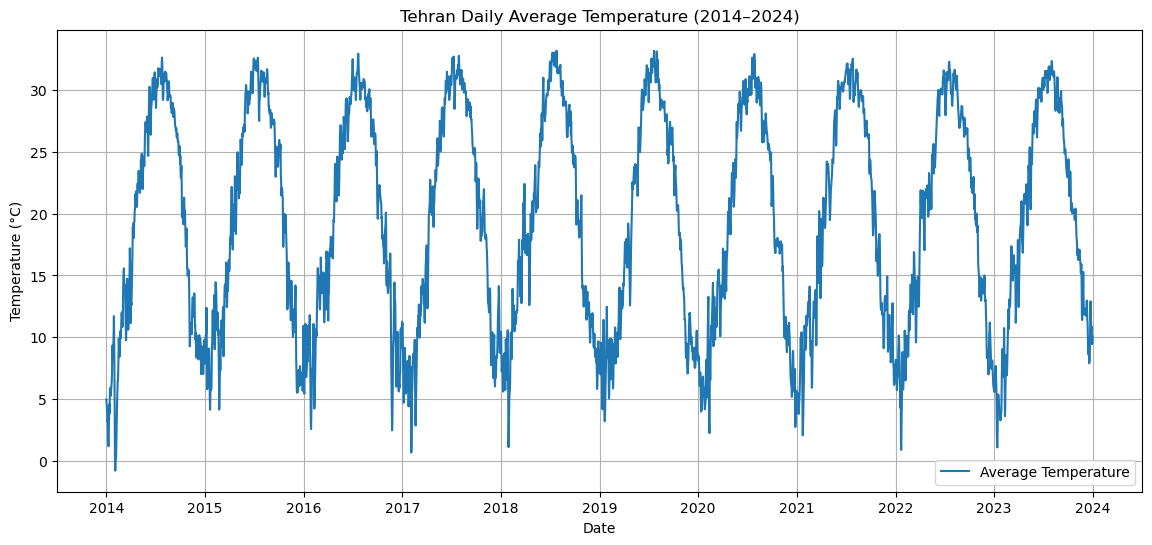

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df["date"], df["t"], label="Average Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Tehran Daily Average Temperature (2014–2024)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["t_scaled"] = scaler.fit_transform(df[["t"]])
ts=df.t_scaled.values
print('len df[t]:',len(df['t']))

len df[t]: 3653


In [6]:
features=[]
labels=[]
for i in range(30,3653):
    features.append(ts[i-30:i])
    labels.append(ts[i])
features=np.array(features)
labels=np.array(labels)
type(features)

numpy.ndarray

In [7]:
print("Features shape:", features.shape)  # (number of samples, 30)
print("Labels shape:", labels.shape)      # (number of samples,)


Features shape: (3623, 30)
Labels shape: (3623,)


## Training Model

In [8]:
features = features.reshape((features.shape[0], features.shape[1], 1))
print("LSTM input shape:", features.shape)
# Expected: (3623, 30, 1)

LSTM input shape: (3623, 30, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=(30, 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (1 value: predicted temperature)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=False
)

In [12]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
91/91 [==============================] - 8s 26ms/step - loss: 0.0494 - val_loss: 0.0031
Epoch 2/100
91/91 [==============================] - 2s 20ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 3/100
91/91 [==============================] - 2s 22ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 4/100
91/91 [==============================] - 2s 20ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 5/100
91/91 [==============================] - 2s 20ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 6/100
91/91 [==============================] - 2s 19ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 7/100
91/91 [==============================] - 2s 21ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 8/100
91/91 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 9/100
91/91 [==============================] - 3s 33ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/100
91/91 [==============================] - 3s 31ms/step - loss: 0.0027 - val_loss: 0.0020

In [16]:
y_hat=model.predict(x_test)

23/23 [==============================] - 1s 9ms/step


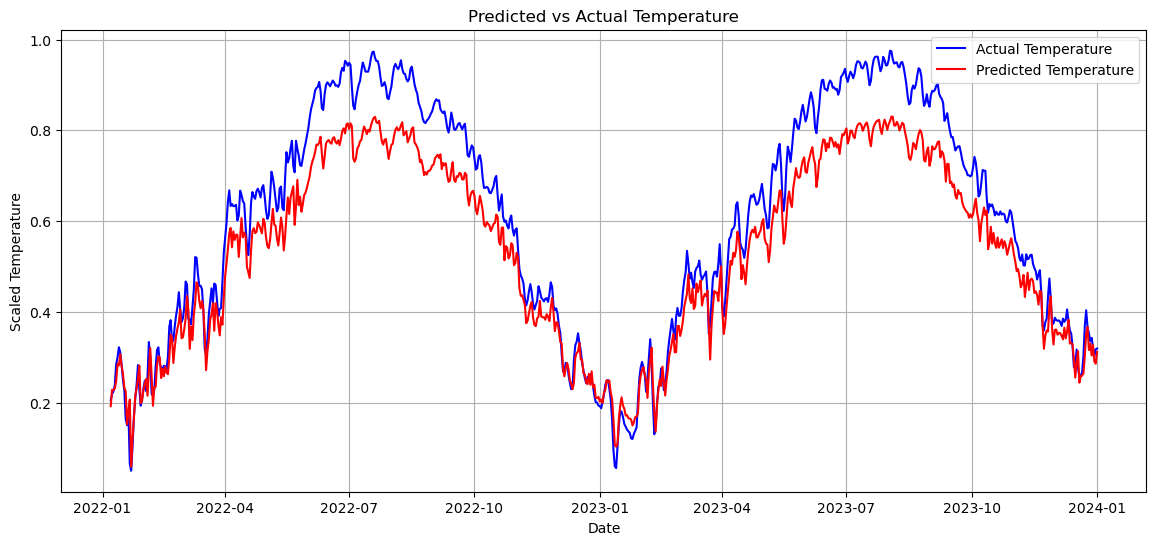

In [21]:
test_dates = df['date'].iloc[-len(y_hat):]

fig, ax = plt.subplots(figsize=(14, 6))
#ax.plot(test_dates, labels[-len(y_hat):], label='Actual Temperature', color='blue')
ax.plot(test_dates, y_test, label='Actual Temperature', color='blue')
ax.plot(test_dates, y_hat, label='Predicted Temperature', color='red')
ax.legend()
plt.title('Predicted vs Actual Temperature')
plt.xlabel('Date')
plt.ylabel('Scaled Temperature')
plt.grid(True)
plt.show()


In [23]:
y_hat_unscaled = scaler.inverse_transform(y_hat)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

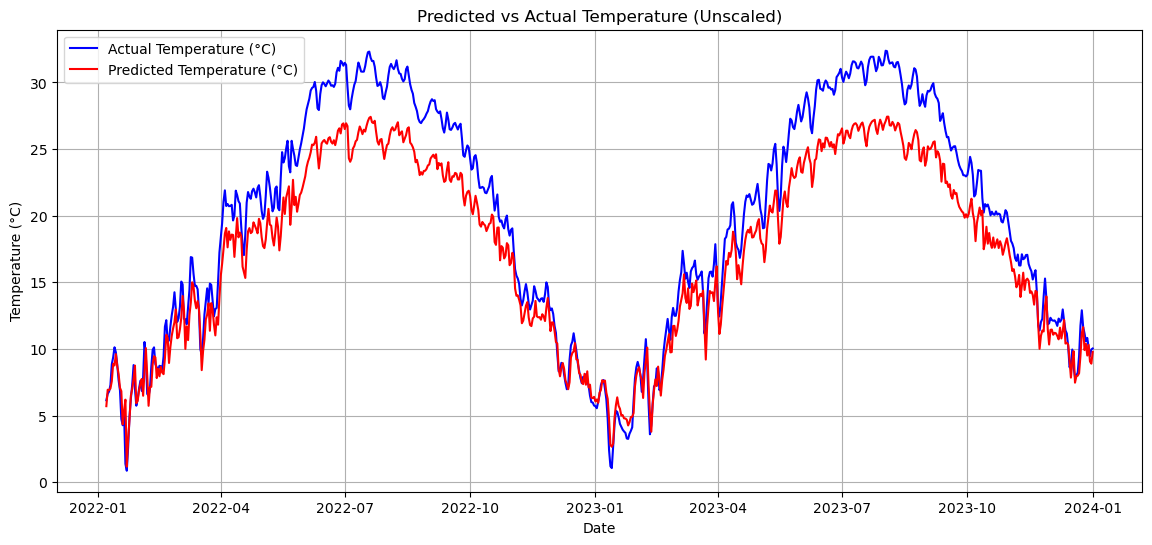

In [26]:
test_dates = df['date'].iloc[-len(y_hat):]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test_dates, y_test_unscaled, label='Actual Temperature (°C)', color='blue')
ax.plot(test_dates, y_hat_unscaled, label='Predicted Temperature (°C)', color='red')
ax.legend()
plt.title('Predicted vs Actual Temperature (Unscaled)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


## Evaluation

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_unscaled, y_hat_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_hat_unscaled))
r2 = r2_score(y_test_unscaled, y_hat_unscaled)

print(f"MAE:  {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
print(f"R²:   {r2:.3f}")


MAE:  2.55 °C
RMSE: 2.98 °C
R²:   0.878


In [28]:
# Save model
model.save('model.h5')

# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']